In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Đọc dữ liệu

In [2]:
btc_data = pd.read_csv('ETH-USD.csv')
bnb_data = pd.read_csv('BNB-USD.csv')

Dữ liệu BTC-USD

In [3]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,133.418152,141.397507,132.650711,140.819412,140.819412,2258709868
1,1/2/2019,141.519516,156.929138,140.650955,155.047684,155.047684,3328240369
2,1/3/2019,155.196045,155.863052,147.198364,149.135010,149.135010,2676164880
3,1/4/2019,148.912888,156.878983,147.907104,154.581940,154.581940,3126192535
4,1/5/2019,154.337418,160.824890,154.337418,155.638596,155.638596,3338211928


Dữ liệu ETH-USD

In [4]:
bnb_data.head()

,Date,Close-Exog
0,1/1/2019,6.075273
1,1/2/2019,6.188613
2,1/3/2019,5.903535
3,1/4/2019,6.065138
4,1/5/2019,6.065543


Kết hợp dữ liệu BTC và ETH

In [5]:
data = pd.merge(btc_data, bnb_data, on='Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close-Exog
0,1/1/2019,133.418152,141.397507,132.650711,140.819412,140.819412,2258709868,6.075273
1,1/2/2019,141.519516,156.929138,140.650955,155.047684,155.047684,3328240369,6.188613
2,1/3/2019,155.196045,155.863052,147.198364,149.135010,149.135010,2676164880,5.903535
3,1/4/2019,148.912888,156.878983,147.907104,154.581940,154.581940,3126192535,6.065138
4,1/5/2019,154.337418,160.824890,154.337418,155.638596,155.638596,3338211928,6.065543


**Dự đoán 30 ngày cho ETH bằng ARIMA**

In [6]:
!pip install pmdarima


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
bnb_data = bnb_data[['Date', 'Close-Exog']]
bnb_data = bnb_data.dropna() # Drop missing values
# bnb_data = bnb_data.reset_index(drop=True) # Reset the index
bnb_data['Date'] = pd.to_datetime(bnb_data['Date'])
bnb_data.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(bnb_data))
test_size = int(0.3 * len(bnb_data))
val_size = len(bnb_data) - train_size - test_size

train_data = bnb_data[:train_size]
test_data = bnb_data[train_size:train_size+test_size]
val_data = bnb_data[train_size+test_size:]
print(bnb_data)

            Close-Exog
Date                  
2019-01-01    6.075273
2019-01-02    6.188613
2019-01-03    5.903535
2019-01-04    6.065138
2019-01-05    6.065543
...                ...
2023-03-27  310.949127
2023-03-28  313.260620
2023-03-29  313.841766
2023-03-30  316.567566
2023-03-31  317.040009

[1551 rows x 1 columns]


In [8]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close-Exog'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7408.002, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7489.267, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7452.095, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7461.182, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7487.778, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7427.045, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7436.328, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7409.996, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7409.997, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7446.960, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7426.639, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7433.997, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7405.328, Time=0.88 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7399.153, Time=0.93 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

ARIMA(order=(3, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [9]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close-Exog'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close-Exog'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [10]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  bnb_data.index[-1]
print(last_index)
next_30_days_index_eth = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index_eth)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days_eth = np.array(next_30_days_index_eth).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days_eth = model.predict(n_periods=len(x_next_30_days_eth)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days_eth)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[297.88532006 299.40236459 302.40425579 299.9957499  299.04545064
 301.17565702 300.78940578 299.53441719 300.38099504 300.84745684
 300.03897844 300.11012693 300.6246283  300.33499026 300.1181417
 300.42122169 300.42400759 300.21656973 300.31235331 300.40935649
 300.29727109 300.28456701 300.36696461 300.3367215  300.29457913
 300.33540741 3

Validation RMSE: 27.660317310698222
Testing RMSE: 135.51391232787813
Validation MAPE: 0.07740781136610221
Testing MAPE: 0.2374260058174036


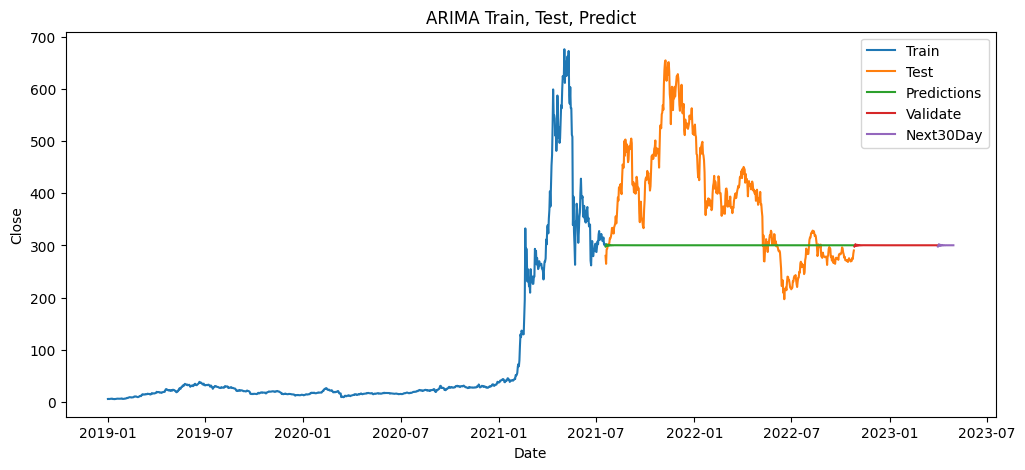

In [11]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close-Exog'])
plt.plot(test_data.index, test_data['Close-Exog'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index_eth,y_next_30_days_eth)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

**SARIMAX**

**<h3>Dự đoán ARIMAX 7-2-1</h3>**

In [12]:

# data = data.reset_index(drop=True) # Reset the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close', 'Close-Exog']]
data = data.dropna() # Drop missing values

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.3 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

930
465
156


In [13]:
from pmdarima.arima import auto_arima
train_exog = train_data[["Close-Exog"]]
model = auto_arima(train_data.Close, 
                   seasonal = True,
                   m=12,
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=10480.813, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10534.801, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10494.783, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10502.274, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10533.477, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=10481.480, Time=0.83 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=10480.166, Time=1.06 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=10493.298, Time=0.29 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=10480.625, Time=3.36 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=10482.620, Time=4.50 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=10478.918, Time=0.89 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=10493.148, Time=0.31 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=10479.244, Time=2.51 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=10479.497, Time=1.16 sec
 ARIM

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_data.Close, 
 exog=train_exog,
 order=(1,1,1),
  seasonal_order=(1,0,0, 12),
 enforce_invertibility=False, enforce_stationarity=False)

c:\APP\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\APP\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [15]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exog = test_data[['Close-Exog']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exog = val_data[['Close-Exog']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

2021-07-19    1814.473923
2021-07-20    1766.198461
2021-07-21    1861.915850
2021-07-22    1868.067986
2021-07-23    1886.567232
                 ...     
2022-10-22    1789.601254
2022-10-23    1809.057716
2022-10-24    1801.911092
2022-10-25    1838.704535
2022-10-26    1859.624171
Freq: D, Name: predicted_mean, Length: 465, dtype: float64
            Close-Exog
Date                  
2022-10-27  286.844116
2022-10-28  298.014191
2022-10-29  304.217957
2022-10-30  313.754791
2022-10-31  326.360718
...                ...
2023-03-27  310.949127
2023-03-28  313.260620
2023-03-29  313.841766
2023-03-30  316.567566
2023-03-31  317.040009

[156 rows x 1 columns]
2021-07-19    1838.494107
2021-07-20    1883.147291
2021-07-21    1903.043083
2021-07-22    1938.851592
2021-07-23    1981.858714
                 ...     
2021-12-17    1932.021309
2021-12-18    1940.155876
2021-12-19    1942.201035
2021-12-20    1951.793624
2021-12-21    1953.456238
Freq: D, Name: predicted_mean, Length: 156, dt

In [16]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)



# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days), exog = y_next_30_days_eth) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
2021-07-19    1877.350126
2021-07-20    1888.032528
2021-07-21    1896.660336
2021-07-22    1890.431008
2021-07-23    1885.731287
2021-07-24    1896.084881
2021-07-25    1895.565119
2021-07-26    1890.574432
2021-07-27    1895.430744
2021-07-28    1897.195056
2021-07-29    1893.397739
2021-07-30    1894.148198
2021-07-31    1895.791573
2021-0

Validation RMSE: 435.9993925836438
Testing RMSE: 826.1444051883083
Validation MAPE: 0.30086193250487314
Testing MAPE: 0.2533953030806731
Validation R2: -3.4387517536198686
Testing R2: 0.35132351858874


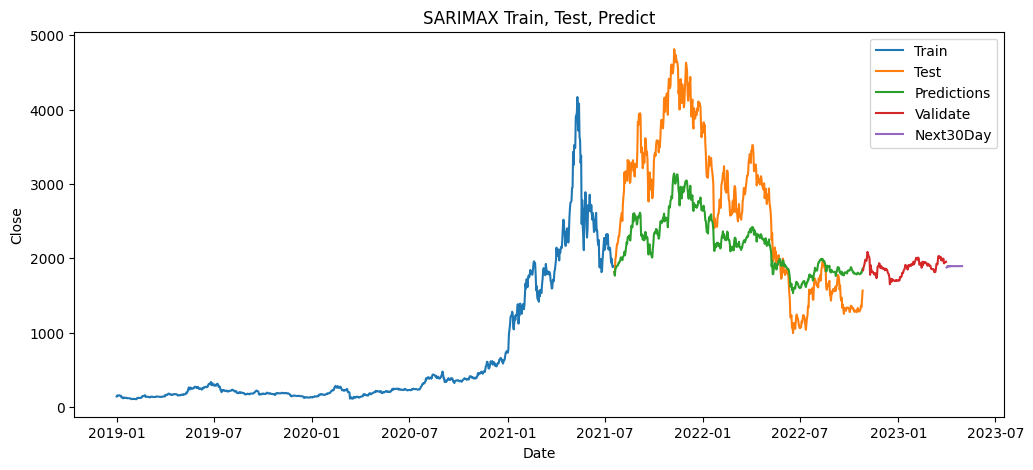

In [17]:
# 8. Tính RMSE
from sklearn.metrics import r2_score


valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
valid_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred)
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation R2:', valid_r2)
print('Testing R2:', test_r2)



# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('SARIMAX Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()